# DINOv2 Embeddings for Accurate Image Classification

In [2]:
import os
import shutil
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import timm
from timm.data import create_transform, ImageDataset
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
from PIL import Image
import random
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# grant access to HF_TOKEN secret
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [3]:
def set_seed(seed=42):
    """Set all seeds"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multiple GPUs
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(0)

# Download the dataset

In [4]:
!wget -O emds6.zip "https://drive.usercontent.google.com/download?id=1G-Vum1Ynq0bVBxHsd-2kQt62KkMe18Ui&export=download&authuser=0&confirm=t&uuid=f67f8d63-c07a-4ec1-b3aa-24917484153a&at=APcmpozoP4iG-g_GESGIAqVbzq1M:1746541093022"
!unzip -q "emds6.zip"

--2025-07-11 12:14:47--  https://drive.usercontent.google.com/download?id=1G-Vum1Ynq0bVBxHsd-2kQt62KkMe18Ui&export=download&authuser=0&confirm=t&uuid=f67f8d63-c07a-4ec1-b3aa-24917484153a&at=APcmpozoP4iG-g_GESGIAqVbzq1M:1746541093022
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.194.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205623475 (196M) [application/octet-stream]
Saving to: ‘emds6.zip’

emds6.zip           100%[===================>] 196.10M  42.8MB/s    in 4.6s    

2025-07-11 12:14:53 (42.8 MB/s) - ‘emds6.zip’ saved [205623475/205623475]



# Visualize the Dataset

Found 21 classes


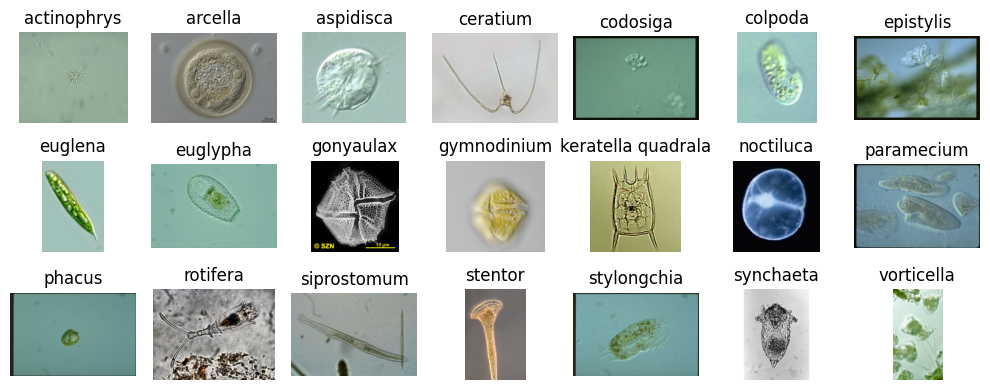

In [5]:
def visualize_class_samples(data_dir, rows=3, cols=7, seed=0):
    """
    Visualize one sample from each class in the training dataset.
    """

    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)

    # Get all class folders
    class_folders = sorted(os.listdir(data_dir))
    print(f"Found {len(class_folders)} classes")

    # Create figure
    plt.figure(figsize=(10, 4))

    # Plot one image from each class
    for i, class_name in enumerate(class_folders):
        # Get class directory
        class_dir = os.path.join(data_dir, class_name)

        # Get all images in the class directory
        images = [f for f in os.listdir(class_dir) if f.endswith('.png')]

        if images:
            # Select a random image
            img_file = random.choice(images)
            img_path = os.path.join(class_dir, img_file)

            # Load and display the image
            img = Image.open(img_path)

            # Calculate position in grid
            plt.subplot(rows, cols, i+1)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis('off')

    plt.tight_layout()
    plt.savefig('/content/class_samples.png', dpi=150)
    plt.show()

# Visualize one image from each class
visualize_class_samples(data_dir='/content/EMDS6_Data/train', rows=3, cols=7)

# Part 1 Zero-Shot Classification with K-NN

Create data loaders for DinoV2 Model

In [6]:
def create_data_loaders(data_dir, batch_size=32, model_name='vit_small_patch14_dinov2', seed=42):
    """
    Create data loaders using timm's transforms and dataset utilities
    """

    # Set seed
    g = torch.Generator()
    g.manual_seed(seed)

    # Create transforms
    data_config = timm.data.resolve_model_data_config(model_name)
    data_config['input_size'] = (3, 518, 518)  # DINOv2's native resolution

    train_transform = timm.data.create_transform(**data_config, is_training=True)
    val_transform = timm.data.create_transform(**data_config, is_training=False)

    # Create datasets using timm's Dataset class
    train_dataset = ImageDataset(root=os.path.join(data_dir, 'train'), transform=train_transform)
    val_dataset = ImageDataset(root=os.path.join(data_dir, 'val'), transform=val_transform)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True,
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True,
        generator=g
    )

    # Get class mappings
    class_names = train_dataset.reader.class_to_idx
    id2label = {v: k for k, v in class_names.items()}
    label2id = class_names

    print(f"Created data loaders:")
    print(f"  Training: {len(train_dataset)} samples, {len(train_loader)} batches")
    print(f"  Validation: {len(val_dataset)} samples, {len(val_loader)} batches")
    print(f"  Number of classes: {len(class_names)}")

    return train_loader, val_loader, id2label, label2id

# Create data loaders
train_loader, val_loader, id2label, label2id = create_data_loaders(
    data_dir='/content/EMDS6_Data',
    batch_size=32, seed=0
)

Created data loaders:
  Training: 672 samples, 21 batches
  Validation: 168 samples, 6 batches
  Number of classes: 21


Extract DinoV2 Features

In [7]:
def extract_features(train_loader, val_loader, model_name='vit_small_patch14_dinov2'):
    """
    Extract features using DINOv2 model from timm.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create a feature extractor using timm
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=0  # Remove classifier head
    ).to(device)

    model = model.eval()

    # Function to extract features
    def extract_batch_features(loader):
        all_features = []
        all_labels = []

        with torch.no_grad():
            for images, labels in tqdm(loader, desc="Extracting features"):
                images = images.to(device)
                features = model(images)
                all_features.append(features.cpu())
                all_labels.append(labels)

        return torch.cat(all_features, dim=0), torch.cat(all_labels, dim=0)

    # Extract features from train and validation sets
    train_features, train_labels = extract_batch_features(train_loader)
    print(f"Training features shape: {train_features.shape}")

    val_features, val_labels = extract_batch_features(val_loader)
    print(f"Validation features shape: {val_features.shape}")

    return train_features, train_labels, val_features, val_labels

# Extract features
train_features, train_labels, val_features, val_labels = extract_features(
    train_loader, val_loader
)

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Extracting features:   0%|          | 0/21 [00:00<?, ?it/s]

Training features shape: torch.Size([672, 384])


Extracting features:   0%|          | 0/6 [00:00<?, ?it/s]

Validation features shape: torch.Size([168, 384])


Zero Shot Classification with KNN

In [8]:
def evaluate_knn_on_features(train_features, train_labels, val_features, val_labels, k):
    """
    Evaluate k-nearest neighbors classifier on extracted DINOv2 features.
    """
    print(f"Evaluating KNN (k={k}) on DINOv2 features...")

    # Convert tensors to numpy arrays
    X_train = train_features.numpy()
    y_train = train_labels.numpy()
    X_val = val_features.numpy()
    y_val = val_labels.numpy()

    # Create and train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on validation set
    y_pred = knn.predict(X_val)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f"KNN Accuracy: {accuracy:.4f}")

    return accuracy

# Evaluate KNN with k=3
knn_accuracy = evaluate_knn_on_features(
    train_features, train_labels, val_features, val_labels, k=5)


Evaluating KNN (k=5) on DINOv2 features...
KNN Accuracy: 0.8393


# Part 2 : Training a linear classifier Head

### Create Data Loaders to load the previously extracted DINOv2 embeddings to the linear head

In [9]:
def create_feature_dataloaders(train_features, train_labels, val_features, val_labels, batch_size=64, seed=42):
    """
    Create data loaders for pre-extracted features.
    """
    # Set generator with seed for reproducible data loading
    g = torch.Generator()
    g.manual_seed(seed)

    # Use timm.data.Dataset for feature datasets
    train_dataset = TensorDataset(train_features, train_labels)
    val_dataset = TensorDataset(val_features, val_labels)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        generator=g
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        generator=g
    )

    print(f"Created feature dataloaders:")
    print(f"  Training: {len(train_dataset)} samples, {len(train_loader)} batches")
    print(f"  Validation: {len(val_dataset)} samples, {len(val_loader)} batches")

    return train_loader, val_loader

# Create feature dataloaders
train_feature_loader, val_feature_loader = create_feature_dataloaders(
    train_features, train_labels, val_features, val_labels, seed=0
)

Created feature dataloaders:
  Training: 672 samples, 11 batches
  Validation: 168 samples, 3 batches


Define a Linear Classification Head

In [10]:

class DINOv2Classifier(nn.Module):
    """Simple linear classifier for DINOv2 features."""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_dim, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


# Create classifier model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_dim = train_features.shape[1]
num_classes = len(id2label)
classifier = DINOv2Classifier(feature_dim, num_classes).to(device)

print(f"Feature dimension: {feature_dim}, Number of classes: {num_classes}")

Feature dimension: 384, Number of classes: 21


Train the Classification Head

In [11]:
def train_model(classifier, train_loader, val_loader, num_epochs, lr):
    """Train the classifier on extracted DINOv2 features."""

    # Setup training
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        classifier.train()
        train_loss, train_correct = 0.0, 0

        for features, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            features, labels = features.to(device), labels.to(device)

            # Forward & backward pass
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track metrics
            train_loss += loss.item() * features.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # Validation phase
        classifier.eval()
        val_loss, val_correct = 0.0, 0

        with torch.no_grad():
            for features, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Val"):
                features, labels = features.to(device), labels.to(device)

                outputs = classifier(features)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * features.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # Calculate epoch metrics
        train_size, val_size = len(train_loader.dataset), len(val_loader.dataset)
        train_loss, train_acc = train_loss / train_size, train_correct / train_size
        val_loss, val_acc = val_loss / val_size, val_correct / val_size

        # Update learning rate
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']

        # Store metrics
        for key, value in zip(
            ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'lr'],
            [train_loss, train_acc, val_loss, val_acc, current_lr]):
            history[key].append(value)

        # Print results & save best model
        print(f"\nEpoch {epoch+1}/{num_epochs}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, lr={current_lr:.6f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(classifier.state_dict(), "/content/best_dinov2_classifier.pth")
            print(f"✓ New best model saved: {val_acc:.4f}")

    return history

# Train the classifier
history = train_model(classifier, train_feature_loader, val_feature_loader, num_epochs=20, lr=0.5)


Epoch 1/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 1/20: train_acc=0.2396, val_acc=0.4881, lr=0.496922
✓ New best model saved: 0.4881


Epoch 2/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 2/20: train_acc=0.5729, val_acc=0.6786, lr=0.487764
✓ New best model saved: 0.6786


Epoch 3/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 3/20: train_acc=0.7143, val_acc=0.8036, lr=0.472752
✓ New best model saved: 0.8036


Epoch 4/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 4/20: train_acc=0.7932, val_acc=0.8869, lr=0.452254
✓ New best model saved: 0.8869


Epoch 5/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 5/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 5/20: train_acc=0.8720, val_acc=0.8690, lr=0.426777


Epoch 6/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 6/20: train_acc=0.8824, val_acc=0.8869, lr=0.396947


Epoch 7/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 7/20: train_acc=0.9107, val_acc=0.9048, lr=0.363498
✓ New best model saved: 0.9048


Epoch 8/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 8/20: train_acc=0.9315, val_acc=0.9167, lr=0.327255
✓ New best model saved: 0.9167


Epoch 9/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 9/20: train_acc=0.9271, val_acc=0.9048, lr=0.289109


Epoch 10/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 10/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 10/20: train_acc=0.9554, val_acc=0.8810, lr=0.250001


Epoch 11/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 11/20: train_acc=0.9494, val_acc=0.9107, lr=0.210892


Epoch 12/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 12/20: train_acc=0.9554, val_acc=0.9167, lr=0.172746


Epoch 13/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 13/20: train_acc=0.9583, val_acc=0.9345, lr=0.136503
✓ New best model saved: 0.9345


Epoch 14/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 14/20: train_acc=0.9688, val_acc=0.9226, lr=0.103054


Epoch 15/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 15/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 15/20: train_acc=0.9673, val_acc=0.9583, lr=0.073224
✓ New best model saved: 0.9583


Epoch 16/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 16/20: train_acc=0.9851, val_acc=0.9405, lr=0.047747


Epoch 17/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 17/20: train_acc=0.9792, val_acc=0.9464, lr=0.027249


Epoch 18/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 18/20: train_acc=0.9836, val_acc=0.9464, lr=0.012237


Epoch 19/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 19/20: train_acc=0.9836, val_acc=0.9464, lr=0.003079


Epoch 20/20 - Train:   0%|          | 0/11 [00:00<?, ?it/s]

Epoch 20/20 - Val:   0%|          | 0/3 [00:00<?, ?it/s]


Epoch 20/20: train_acc=0.9807, val_acc=0.9464, lr=0.000001


Plot the Training Results

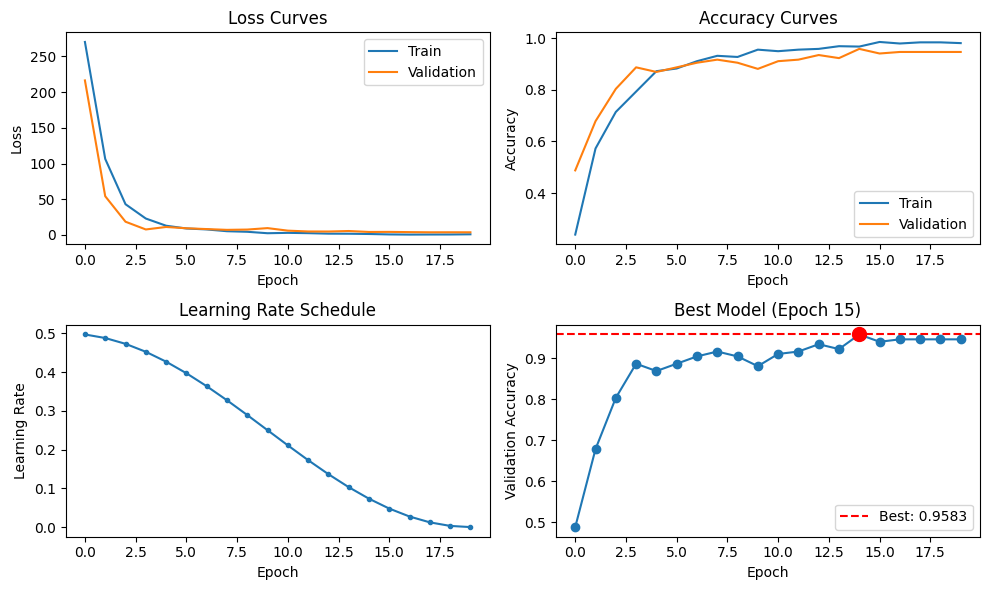

In [12]:
# Plot training results
def plot_training_history(history):
    """Visualize training metrics."""
    plt.figure(figsize=(10, 6))

    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    # Plot learning rate
    plt.subplot(2, 2, 3)
    plt.plot(history['lr'], marker='.')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')

    # Plot best validation accuracy
    plt.subplot(2, 2, 4)
    plt.plot(history['val_acc'], marker='o')
    best_acc = max(history['val_acc'])
    best_epoch = history['val_acc'].index(best_acc)
    plt.axhline(y=best_acc, color='r', linestyle='--',
                label=f'Best: {best_acc:.4f}')
    plt.scatter(best_epoch, best_acc, c='red', s=100, zorder=5)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Model (Epoch {best_epoch+1})')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/training_results.png', dpi=150)
    plt.show()

# Plot training history
plot_training_history(history)

# Accuracy Comparison

In [13]:
best_classifier_acc = max(history['val_acc']) if 'history' in globals() else 0
print("\nModel Comparison:")
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"Linear Classifier Best Accuracy: {best_classifier_acc:.4f}")


Model Comparison:
KNN Accuracy: 0.8393
Linear Classifier Best Accuracy: 0.9583


Testing using a single image

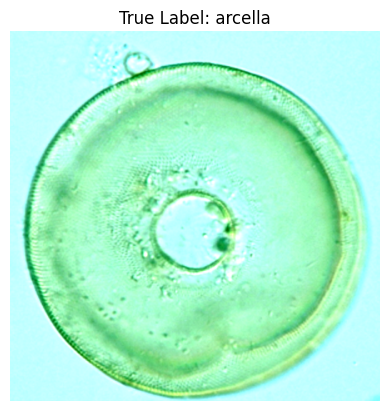

True Label:      arcella
Zero-Shot (kNN): arcella
Linear Head:     arcella


In [28]:
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.neighbors import KNeighborsClassifier

# Define kNN classifier (fit it on training features only once)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_features.numpy(), train_labels.numpy())

# Grab one batch from validation loader
images, labels = next(iter(val_loader))

# Pick an image index
idx = 10
image_tensor = images[idx]
true_label = labels[idx].item()

# Unnormalize for visualization
unnorm = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])
image_vis = unnorm(image_tensor).clamp(0, 1)

# Show image
plt.imshow(image_vis.permute(1, 2, 0))
plt.title(f"True Label: {id2label[true_label]}")
plt.axis('off')
plt.show()

# Get DINOv2 features
image_input = image_tensor.unsqueeze(0).to(device)
with torch.no_grad():
    feature = dinov2(image_input)

# Predict using kNN
knn_pred = knn.predict(feature.cpu().numpy())[0]

# Predict using linear head
with torch.no_grad():
    logits = classifier(feature)
    linear_pred = torch.argmax(logits, dim=1).item()

# Display predictions
print(f"True Label:      {id2label[true_label]}")
print(f"Zero-Shot (kNN): {id2label[knn_pred]}")
print(f"Linear Head:     {id2label[linear_pred]}")
